In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
from astropy.stats import LombScargle
import theano.tensor as tt
import tqdm

In [2]:
%run setup.py

ModuleNotFoundError: No module named 'corner'

In [3]:
import numpy as np
from lightkurve import search_lightcurvefile

def get_lightcurve(target, **kwargs):
    lc_collection = search_lightcurvefile(target, **kwargs).download_all()

    lc = lc_collection[0].PDCSAP_FLUX.normalize()
    for l in lc_collection[1:]:
        lc = lc.append(l.PDCSAP_FLUX.normalize())

    lc = lc.remove_nans()
    magnitude = -2.5 * np.log10(lc.flux)
    magnitude = magnitude - np.average(magnitude)
    return lc.time, lc.flux

time, mag = get_lightcurve('KIC 10080943', cadence='long')
time -= np.mean(time)
mag *= 1000

#time = time[:len(time)//2]
#mag = mag[:len(mag)//2]

In [4]:
def estimate_frequencies(x, y, max_peaks=9, oversample=4.0, fmin=None, fmax=None):
    tmax = x.max()
    tmin = x.min()
    dt = np.median(np.diff(x))
    df = 1.0 / (tmax - tmin)
    ny = 0.5 / dt

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = ny

    freq = np.arange(fmin, fmax, df / oversample)
    power = LombScargle(x, y).power(freq)

    # Find peaks
    peak_inds = (power[1:-1] > power[:-2]) & (power[1:-1] > power[2:])
    peak_inds = np.arange(1, len(power)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(power[peak_inds])][::-1]
    peaks = []
    for j in range(max_peaks):
        i = peak_inds[0]
        freq0 = freq[i]
        alias = 2.0*ny - freq0

        m = np.abs(freq[peak_inds] - alias) > 25*df
        m &= np.abs(freq[peak_inds] - freq0) > 25*df

        peak_inds = peak_inds[m]
        peaks.append(freq0)
    peaks = np.array(peaks)

    with pm.Model():
        nu = pm.Bound(pm.Normal, lower=fmin, upper=fmax)("nu", mu=peaks, sd=10, testval=peaks, shape=peaks.shape)
        arg = 2*np.pi*nu[None, :]*x[:, None]
        D = tt.concatenate((tt.cos(arg), tt.sin(arg), tt.ones((len(x), 1))), axis=1)
        DTD = tt.dot(D.T, D)
        DTy = tt.dot(D.T, y)
        w = tt.slinalg.solve(DTD, DTy)
        mod = tt.dot(D, w)
        pm.Normal("obs", mu=mod, observed=y)
        map_soln = xo.optimize()
    
    plt.plot(freq, power)
    plt.xlim(fmin, fmax)
    for n in map_soln["nu"]:
        plt.axvline(n, color="k", alpha=0.1, lw=2)
    
    return map_soln["nu"]

optimizing logp for variables: ['nu_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -725540.1645925796 -> -724217.8158285487


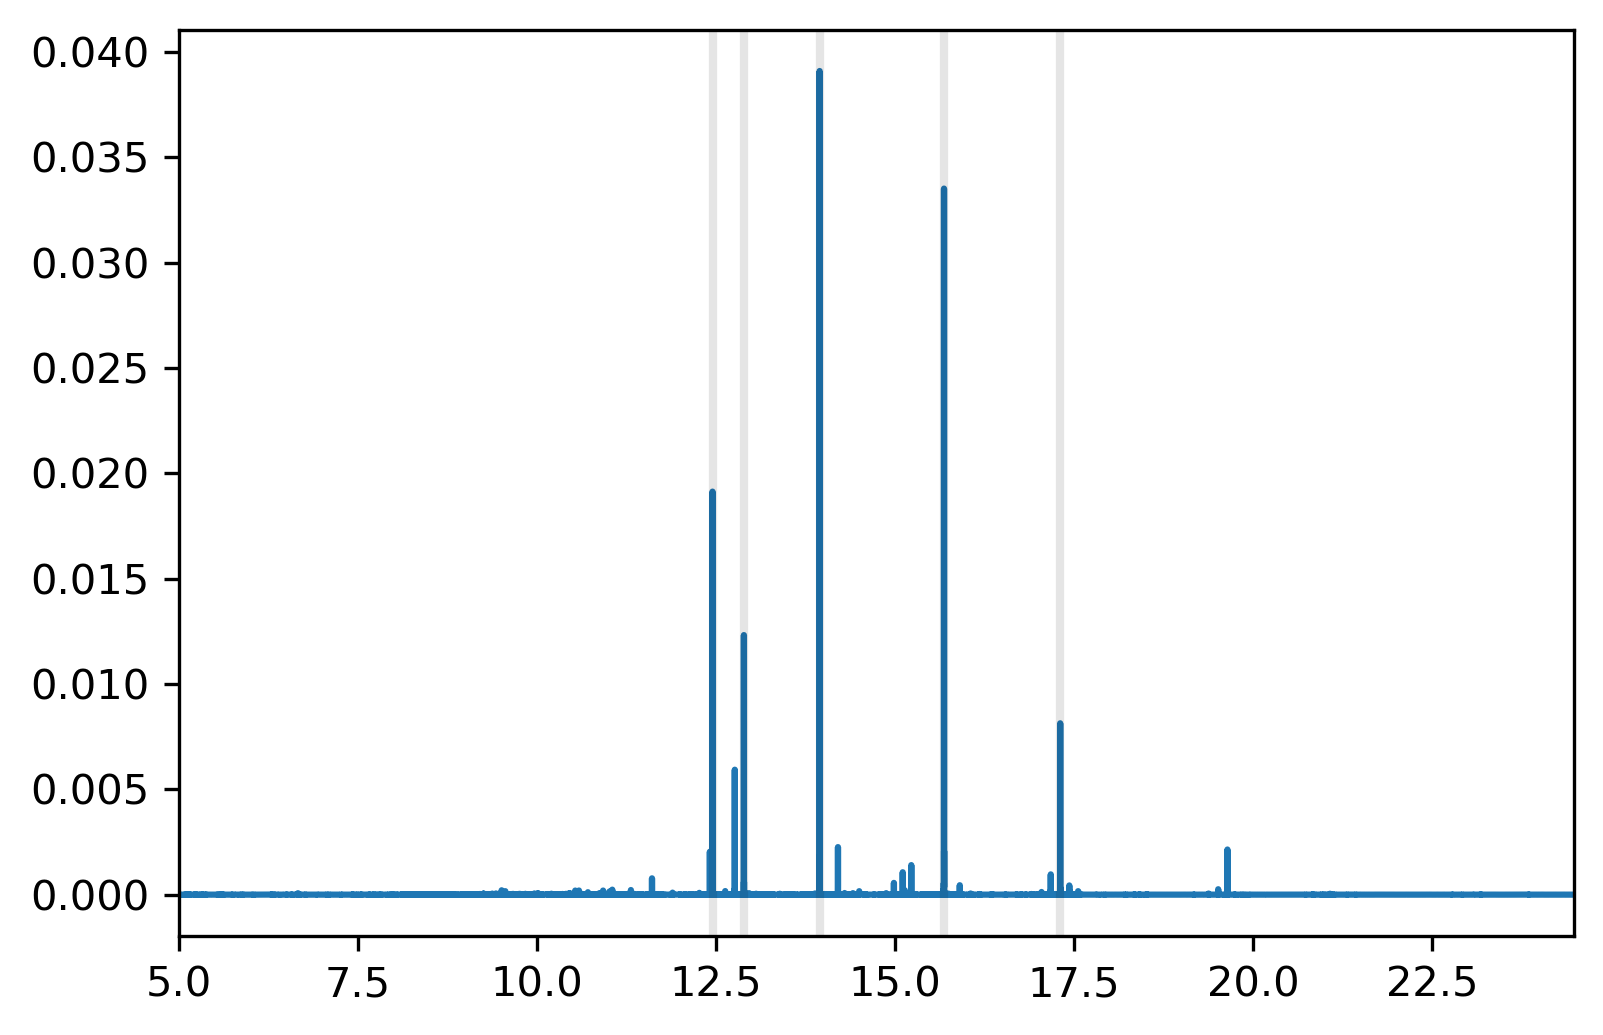

In [5]:
freq = estimate_frequencies(time, mag, max_peaks=5, fmin=5)

In [6]:
freq

array([13.94758545, 15.68332966, 12.4525753 , 12.89054149, 17.3050408 ])

In [6]:
from tqdm import tqdm_notebook as tqdm

with pm.Model() as simple_model:
    
    period = pm.Flat("period", testval=10.0)
    nu = pm.Flat("nu", testval=15)
    
    phi = xo.distributions.Angle("phi")
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(10))
    drift = pm.Normal("drift", mu=0, sd=1.0)
    
    M = 2.0 * np.pi * time / period - phi
    
    factor = 2. * np.pi * nu
    A = factor * (1 + drift) * time
    B = -factor * (tt.exp(logasini) / 86400) * tt.sin(M)
    
    sinarg = tt.sin(A+B)
    cosarg = tt.cos(A+B)
    
    DT = tt.stack((sinarg, cosarg, tt.ones_like(sinarg)))
    w = tt.slinalg.solve(tt.dot(DT, DT.T), tt.dot(DT, mag))
    pm.Deterministic("w", w)
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(DT.T, w)
        
    pm.Normal("obs", mu=lc_model, observed=mag)
    
    fit_params = [v for v in simple_model.vars if v.name not in ["period", "nu"]]

def run_fit(p, nu):
    with simple_model:
        start = dict(simple_model.test_point)
        start["period"] = p
        start["nu"] = nu
        point, info = xo.optimize(start, vars=fit_params, return_info=True, verbose=False)
    return -info.fun, point

#periods = np.exp(np.linspace(np.log(10), np.log(25), 50))
periods = np.linspace(8,20, 100)
results = []
for f in freq:
    results.append([run_fit(p, f) for p in tqdm(periods)])

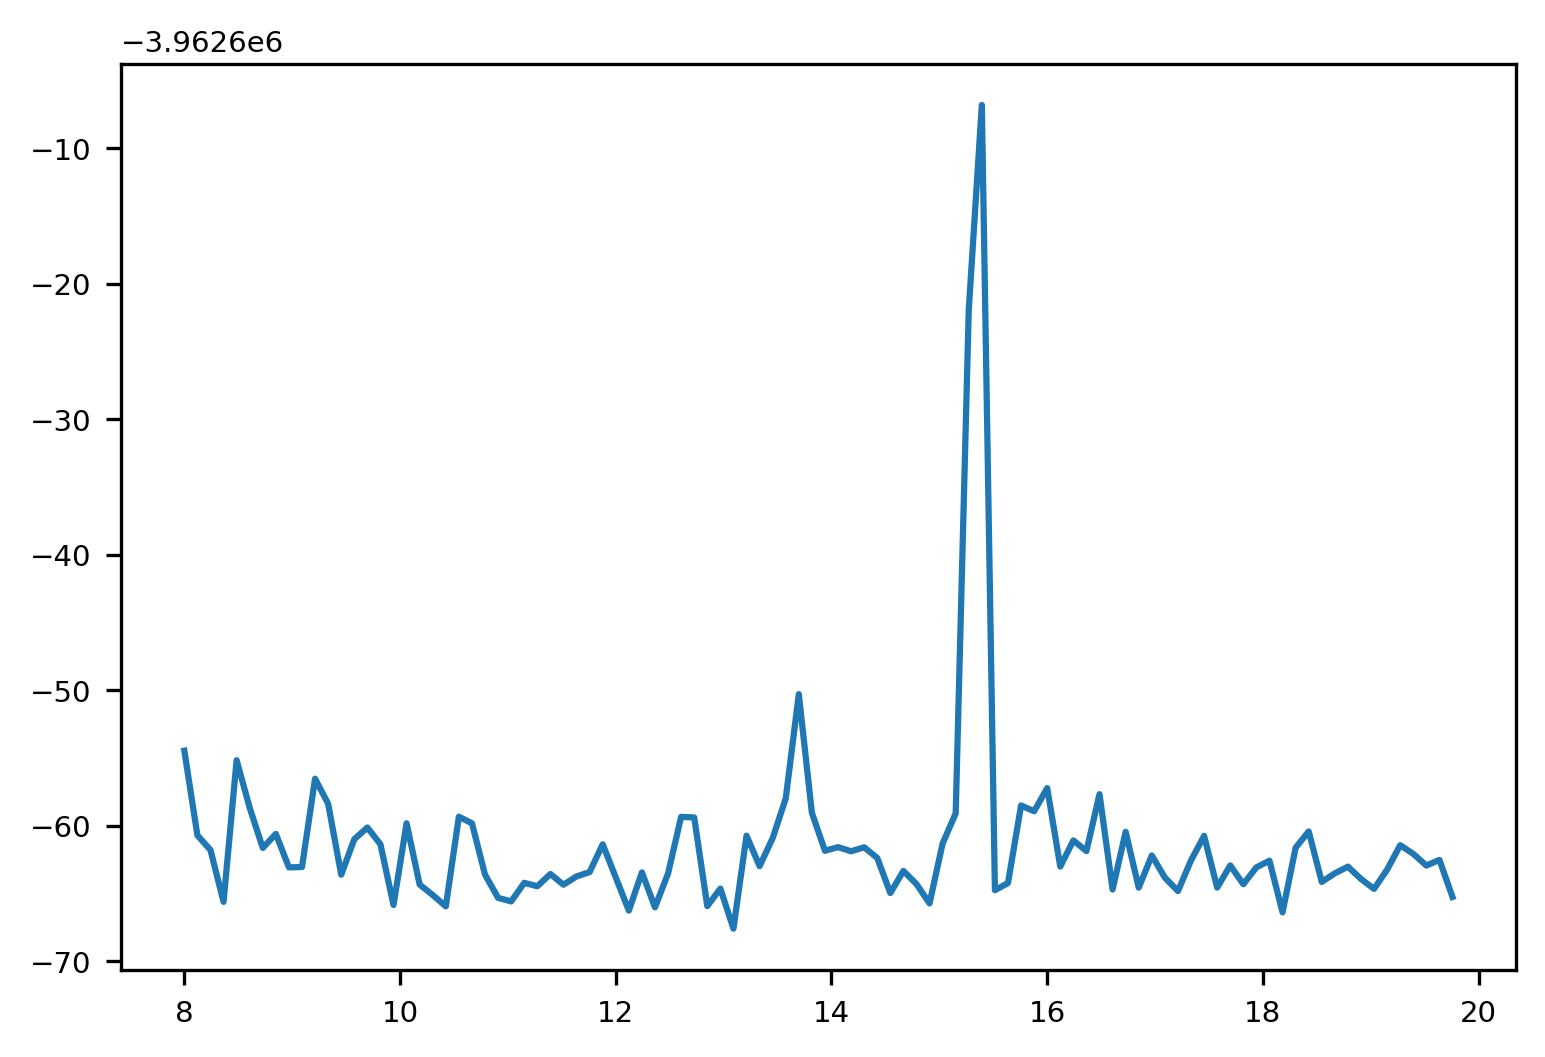

In [7]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

Text(0, 0.5, 'asini')

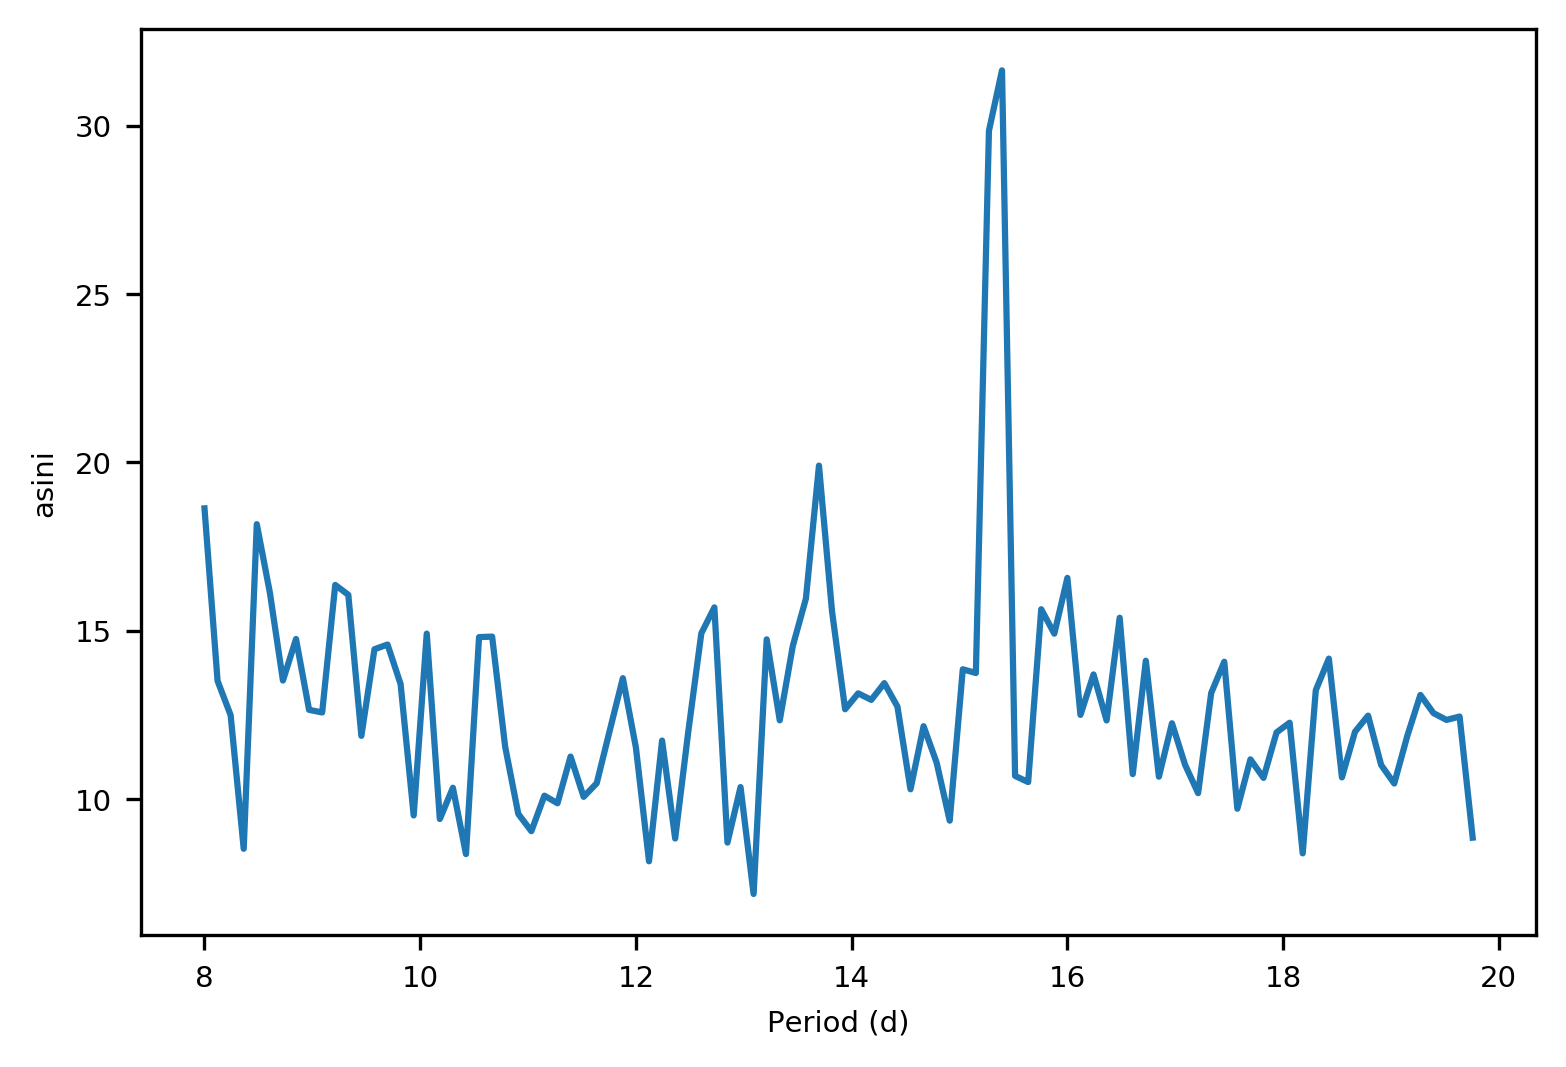

In [8]:
ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
sm = np.mean(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);
plt.xlabel('Period (d)')
plt.ylabel('asini')

In [9]:
period_guess = periods[period_ind]
a_guess = np.max(sm)
period_guess, a_guess

(15.393939393939394, 31.640300060980582)

In [26]:
def get_phase(nu, t, y):
    arg = 2*np.pi*nu[None, :]*t[:, None]
    D = np.concatenate((np.sin(arg), np.cos(arg),
                        np.ones((len(t), 1))), axis=1)
    DT = D.T
    DTD = np.dot(DT, D)
    w = np.linalg.solve(DTD, np.dot(D.T, y))
    return np.arctan2(w[:len(nu)], w[len(nu):2*len(nu)]) / (2*np.pi*nu)

In [77]:
t0s = np.arange(time.min(), time.max(), 5.5)
phases = np.empty((len(t0s)-1, len(freq)))
phases[:] = np.nan
for i, t0 in tqdm(enumerate(t0s[:-1]), total=len(t0s)-1):
    m = (t0 <= time) & (time < t0s[i+1])
    if m.sum() < 100:
        continue
    phases[i] = get_phase(freq, time[m], mag[m])
    
# phases -= np.nanmean(phases, axis=0)
full = np.mean(phases, axis=1)

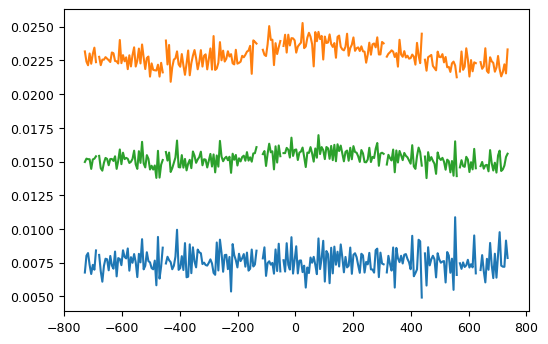

In [78]:
plt.plot(t0s[:-1], phases)
plt.plot(t0s[:-1], full);

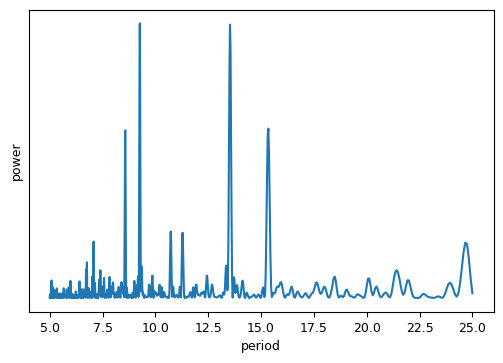

In [63]:
m = np.isfinite(phases[:, 0])
res = xo.estimators.lomb_scargle_estimator(t0s[:-1][m], phases[m, 0], min_period=5, max_period=25)
f, p = res["periodogram"]
plt.plot(1 / f, p)
#plt.axvline(res["peaks"][0]["period"], color="k")
plt.xlabel("period")
plt.ylabel("power")
plt.yticks([]);

(0, 50)

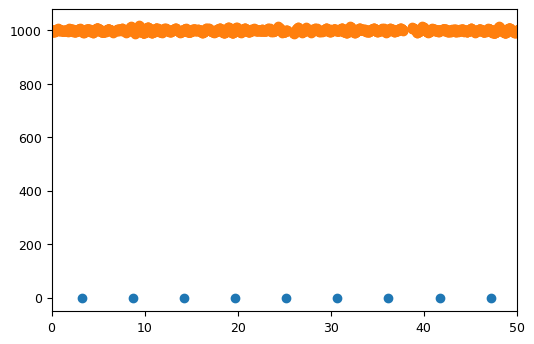

In [73]:
plt.scatter(t0s[:-1][m], phases[m,0])
plt.scatter(time, mag)

plt.xlim(0,50)